In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [ ]:
root_path = "/content/drive/MyDrive/Dataset/Solar/"
categories_paths = os.listdir(root_path)
categories_paths = [os.path.join(root_path, cat_path) for cat_path in categories_paths]

In [ ]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image

# Set paths (change to your actual paths)
IMAGE_DIR = "/content/drive/MyDrive/Dataset/Solar/images"   # e.g., "/content/drive/MyDrive/solar/images"
MASK_DIR = "/content/drive/MyDrive/Dataset/Solar/labels"   # e.g., "/content/drive/MyDrive/solar/labels"

# Target size for resizing
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Get all image file names
image_filenames = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.bmp')])
mask_filenames = sorted([f for f in os.listdir(MASK_DIR) if f.endswith('.bmp')])

# Safety check
assert len(image_filenames) == len(mask_filenames), "Mismatch in image and mask count!"

def process_pair(image_path, mask_path):
    # Load image and mask
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")  # Grayscale

    # Resize
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))
    mask = mask.resize((IMG_WIDTH, IMG_HEIGHT))

    # Convert to numpy
    image = np.array(image) / 255.0
    mask = np.array(mask)

    # Binarize mask: 0 = background, 1 = solar panel
    mask = np.where(mask > 0, 1, 0).astype(np.uint8)

    return image, mask[..., np.newaxis]  # add channel dimension to mask

# Create dataset
images = []
masks = []

for img_name, msk_name in zip(image_filenames, mask_filenames):
    img_path = os.path.join(IMAGE_DIR, img_name)
    msk_path = os.path.join(MASK_DIR, msk_name)
    img, msk = process_pair(img_path, msk_path)
    images.append(img)
    masks.append(msk)

images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.uint8)

print("Images shape:", images.shape)
print("Masks shape:", masks.shape)


Images shape: (164, 256, 256, 3)
Masks shape: (164, 256, 256, 1)


In [ ]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Constants
IMAGE_DIR = "/content/drive/MyDrive/Dataset/Solar/images"
MASK_DIR  = "/content/drive/MyDrive/Dataset/Solar/labels"
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

# List files
image_filenames = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.bmp')])
mask_filenames  = sorted([f for f in os.listdir(MASK_DIR) if f.endswith('.bmp')])

assert len(image_filenames) == len(mask_filenames), "Mismatch in number of images and masks"

def process_pair(image_path, mask_path):
    image = Image.open(image_path).convert("RGB").resize((IMG_WIDTH, IMG_HEIGHT))
    mask = Image.open(mask_path).convert("L").resize((IMG_WIDTH, IMG_HEIGHT))

    image = np.array(image) / 255.0
    mask = (np.array(mask) > 0).astype(np.uint8)[..., np.newaxis]

    return image, mask

# Load all images/masks into memory
images, masks = [], []

for img_name, msk_name in zip(image_filenames, mask_filenames):
    img_path = os.path.join(IMAGE_DIR, img_name)
    msk_path = os.path.join(MASK_DIR, msk_name)
    img, msk = process_pair(img_path, msk_path)
    images.append(img)
    masks.append(msk)

images = np.array(images, dtype=np.float32)
masks  = np.array(masks,  dtype=np.uint8)

print("Total images loaded:", images.shape)
print("Total masks loaded:", masks.shape)

# Split into train and val
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Convert to TensorFlow Datasets
def to_tf_dataset(images, masks, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))

    def preprocess(img, mask):
        img = tf.cast(img, tf.float32)
        mask = tf.cast(mask, tf.uint8)
        return img, mask

    dataset = dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(100).batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset

train_ds = to_tf_dataset(X_train, y_train)
val_ds   = to_tf_dataset(X_val, y_val)

print("Train dataset:", train_ds)
print("Validation dataset:", val_ds)


Total images loaded: (164, 256, 256, 3)
Total masks loaded: (164, 256, 256, 1)
Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>


In [ ]:
from tensorflow.keras import layers, models

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bridge
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Build and compile
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Create callbacks
checkpoint_cb = ModelCheckpoint("best_unet_model.h5", save_best_only=True, monitor='val_loss', mode='min')
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8681 - loss: 0.7925   

17/17 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step - accuracy: 0.8686 - loss: 0.7824 - val_accuracy: 0.8843 - val_loss: 0.4718
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8516 - loss: 0.4910

17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 541ms/step - accuracy: 0.8531 - loss: 0.4852 - val_accuracy: 0.8843 - val_loss: 0.3425
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8780 - loss: 0.3517

17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 536ms/step - accuracy: 0.8780 - loss: 0.3512 - val_accuracy: 0.8843 - val_loss: 0.3303
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - accuracy: 0.8793 - loss: 0.3304 - val_accuracy: 0.8843 - val_loss: 0.3422
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9075 - loss: 0.2717

17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 534ms/step - accuracy: 0.9059 - loss: 0.2734 - val_accuracy: 0.8843 - val_loss: 0.2745
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8716 - loss: 0.2529

17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 542ms/step - accuracy: 0.8721 - loss: 0.2516 - val_accuracy: 0.9216 - val_loss: 0.1882
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 451ms/step - accuracy: 0.9009 - loss: 0.2243 - val_accuracy: 0.9273 - val_loss: 0.1971
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9292 - loss: 0.1889

17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 529ms/step - accuracy: 0.9294 - loss: 0.1877 - val_accuracy: 0.9297 - val_loss: 0.1705
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 449ms/step - accuracy: 0.9366 - loss: 0.1588 - val_accuracy: 0.8902 - val_loss: 0.2688
Epoch 10/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 446ms/step - accuracy: 0.9277 - loss: 0.2010 - val_accuracy: 0.9308 - val_loss: 0.1740
Epoch 11/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9417 - loss: 0.1626

17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 642ms/step - accuracy: 0.9420 - loss: 0.1617 - val_accuracy: 0.9280 - val_loss: 0.1656
Epoch 12/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9527 - loss: 0.1244

17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 528ms/step - accuracy: 0.9525 - loss: 0.1251 - val_accuracy: 0.9325 - val_loss: 0.1593
Epoch 13/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 449ms/step - accuracy: 0.9468 - loss: 0.1384 - val_accuracy: 0.9322 - val_loss: 0.1672
Epoch 14/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 448ms/step - accuracy: 0.9453 - loss: 0.1395 - val_accuracy: 0.9147 - val_loss: 0.2006
Epoch 15/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms/step - accuracy: 0.9442 - loss: 0.1416 - val_accuracy: 0.9340 - val_loss: 0.1605
Epoch 16/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 452ms/step - accuracy: 0.9505 - loss: 0.1273 - val_accuracy: 0.9265 - val_loss: 0.1923
Epoch 17/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 450ms/step - accuracy: 0.9603 - loss: 0.1073 - val_accuracy: 0.9270 - val_loss: 0.1767


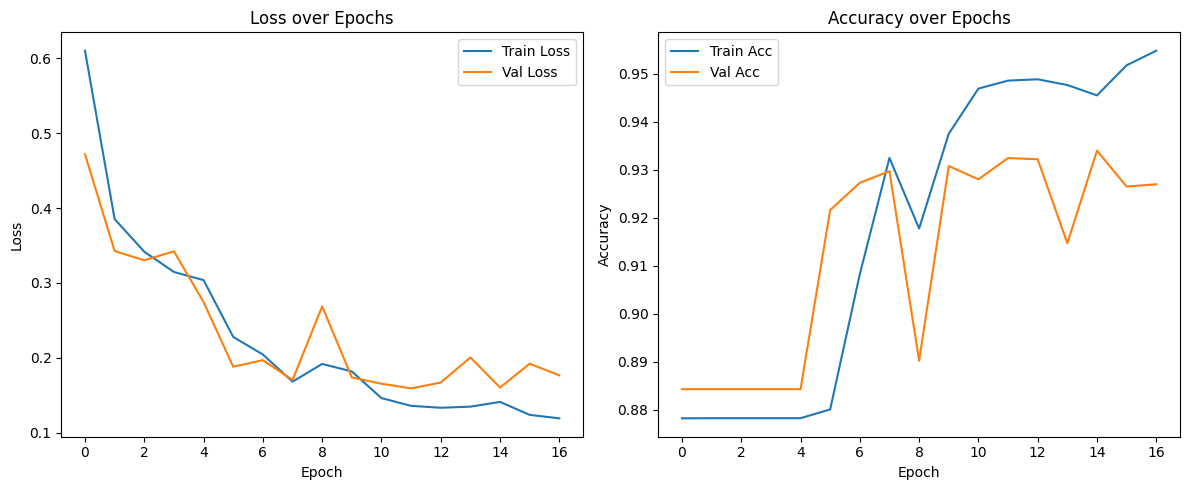

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Validation samples loaded: 33
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


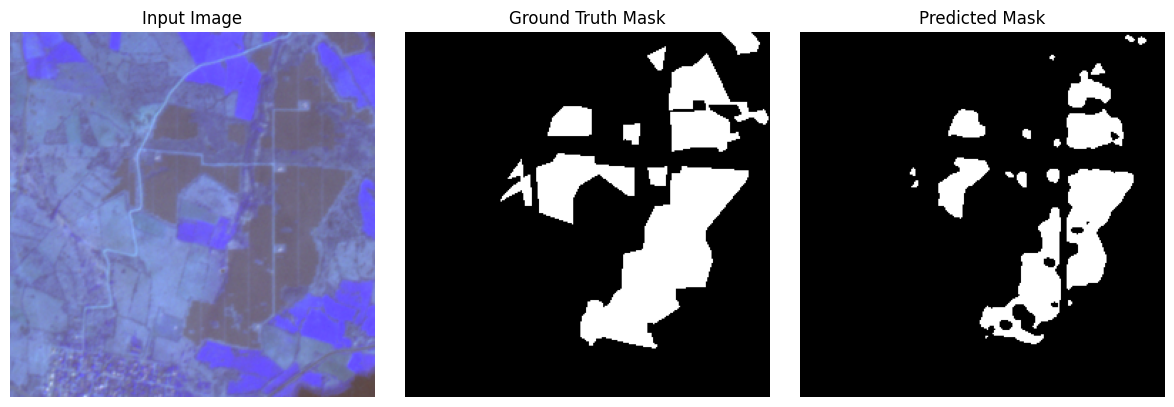

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


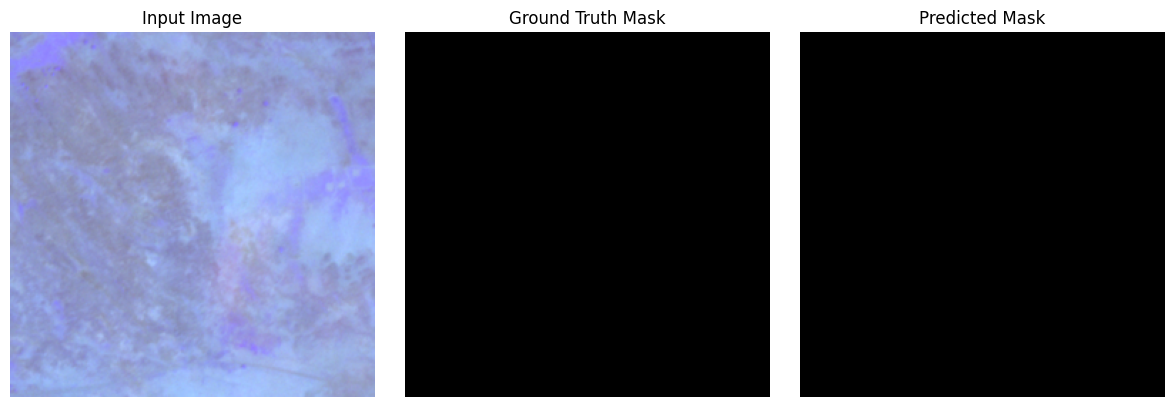

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


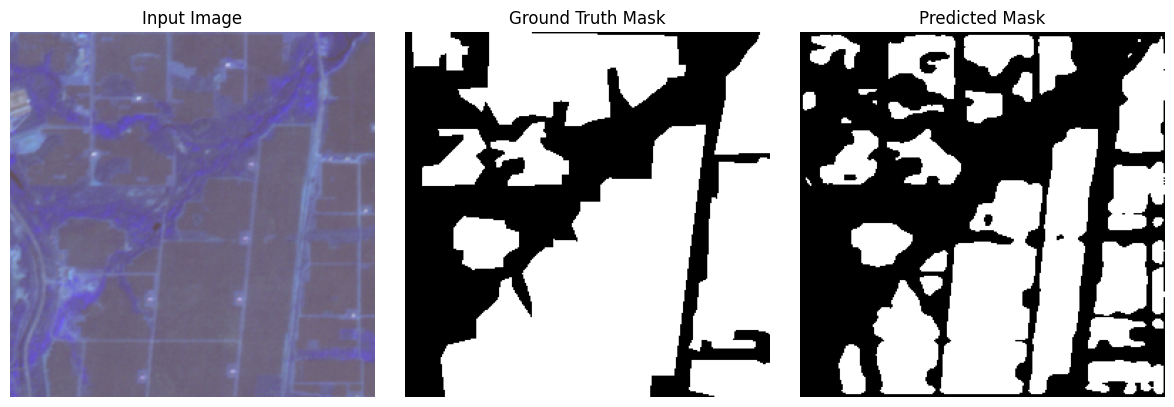

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


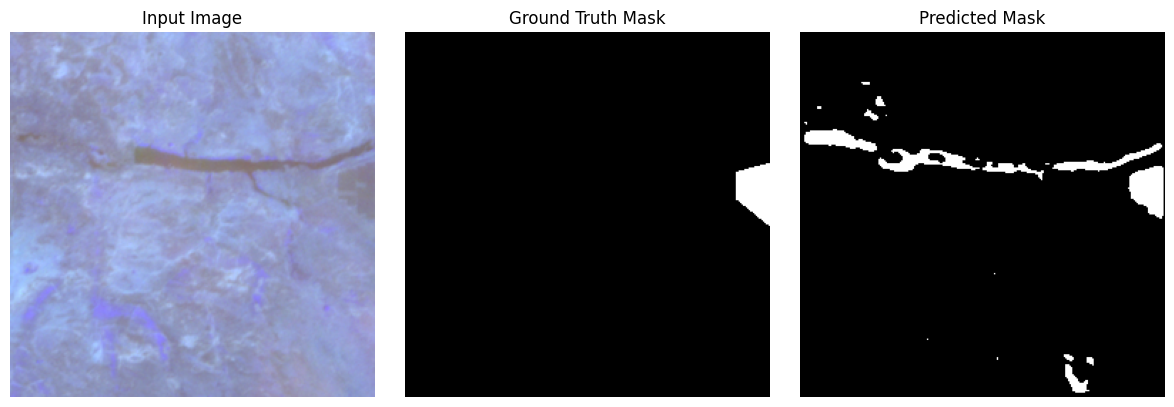

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


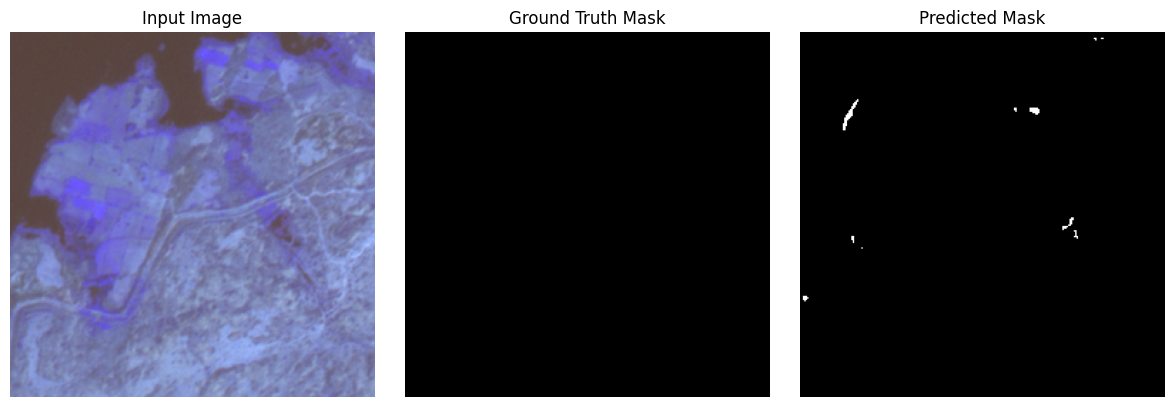

In [ ]:
import random

# Load the best model
from tensorflow.keras.models import load_model
model = load_model("best_unet_model.h5")

# Get a few samples from the validation dataset
val_images = list(val_ds.unbatch().as_numpy_iterator())
print("Validation samples loaded:", len(val_images))

# Plot a few predictions
def display_predictions(num=3):
    for i in range(num):
        img, true_mask = random.choice(val_images)
        img_input = np.expand_dims(img, axis=0)
        pred_mask = model.predict(img_input)[0]

        # Threshold prediction to get binary mask
        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

        # Plotting
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask.squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask_bin.squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

# Run the function
display_predictions(num=5)
